## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [28]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2020-04-05 17:45:43--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.105.253
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.105.253|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip.1’

train-test-data.zip 100%[===================>] 322.93M  84.0MB/s    in 4.0s    

2020-04-05 17:45:47 (80.2 MB/s) - ‘/data/train-test-data.zip.1’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip


<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [29]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np
import cv2

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

/home/workspace/models.py:53: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  I.xavier_uniform(self.fc1.weight.data)


Net(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.1)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.2)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.3)
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, 

/home/workspace/models.py:54: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  I.xavier_uniform(self.fc2.weight.data)
/home/workspace/models.py:55: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  I.xavier_uniform(self.fc3.weight.data)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [31]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset

# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [32]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [33]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [34]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [35]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [36]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [37]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [38]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

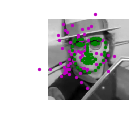

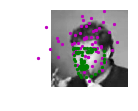

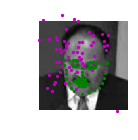

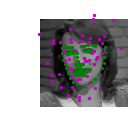

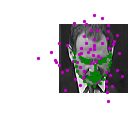

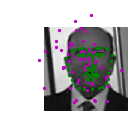

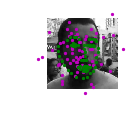

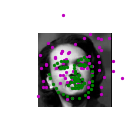

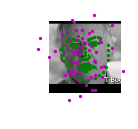

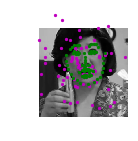

In [39]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [40]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.SmoothL1Loss()

optimizer = optim.Adam(net.parameters(), lr = 0.001)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [41]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [42]:
# train your network
n_epochs = 14 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    train_net(n_epochs)

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.5973298966884613
Epoch: 1, Batch: 20, Avg. Loss: 0.5061904191970825
Epoch: 1, Batch: 30, Avg. Loss: 0.46032982766628266
Epoch: 1, Batch: 40, Avg. Loss: 0.39487092196941376
Epoch: 1, Batch: 50, Avg. Loss: 0.3489451825618744
Epoch: 1, Batch: 60, Avg. Loss: 0.3291672170162201
Epoch: 1, Batch: 70, Avg. Loss: 0.3304889053106308
Epoch: 1, Batch: 80, Avg. Loss: 0.3118910610675812
Epoch: 1, Batch: 90, Avg. Loss: 0.289813956618309
Epoch: 1, Batch: 100, Avg. Loss: 0.2932647854089737
Epoch: 1, Batch: 110, Avg. Loss: 0.28149384409189226
Epoch: 1, Batch: 120, Avg. Loss: 0.2663411110639572
Epoch: 1, Batch: 130, Avg. Loss: 0.2572675719857216
Epoch: 1, Batch: 140, Avg. Loss: 0.2511157751083374
Epoch: 1, Batch: 150, Avg. Loss: 0.24459743201732637
Epoch: 1, Batch: 160, Avg. Loss: 0.23951259404420852
Epoch: 1, Batch: 170, Avg. Loss: 0.2306873083114624
Epoch: 1, Batch: 180, Avg. Loss: 0.21478325873613358
Epoch: 1, Batch: 190, Avg. Loss: 0.22515954822301865
Epoch: 1, Batch

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.15105396881699562
Epoch: 2, Batch: 20, Avg. Loss: 0.13769690021872522
Epoch: 2, Batch: 30, Avg. Loss: 0.1375643327832222
Epoch: 2, Batch: 40, Avg. Loss: 0.13120822310447694
Epoch: 2, Batch: 50, Avg. Loss: 0.11858783289790154
Epoch: 2, Batch: 60, Avg. Loss: 0.1202742725610733
Epoch: 2, Batch: 70, Avg. Loss: 0.11492743715643883
Epoch: 2, Batch: 80, Avg. Loss: 0.10998228713870048
Epoch: 2, Batch: 90, Avg. Loss: 0.10570601373910904
Epoch: 2, Batch: 100, Avg. Loss: 0.10103078112006188
Epoch: 2, Batch: 110, Avg. Loss: 0.11005859151482582
Epoch: 2, Batch: 120, Avg. Loss: 0.10769298151135445
Epoch: 2, Batch: 130, Avg. Loss: 0.10239018723368645
Epoch: 2, Batch: 140, Avg. Loss: 0.09880121201276779
Epoch: 2, Batch: 150, Avg. Loss: 0.08843081071972847
Epoch: 2, Batch: 160, Avg. Loss: 0.10086095929145814
Epoch: 2, Batch: 170, Avg. Loss: 0.08790168091654778
Epoch: 2, Batch: 180, Avg. Loss: 0.10848654061555862
Epoch: 2, Batch: 190, Avg. Loss: 0.10174821652472019
Epoc

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.0764012437313795
Epoch: 3, Batch: 20, Avg. Loss: 0.0888659592717886
Epoch: 3, Batch: 30, Avg. Loss: 0.06698158718645572
Epoch: 3, Batch: 40, Avg. Loss: 0.06273291110992432
Epoch: 3, Batch: 50, Avg. Loss: 0.07934092022478581
Epoch: 3, Batch: 60, Avg. Loss: 0.06467411555349827
Epoch: 3, Batch: 70, Avg. Loss: 0.07943872846662998
Epoch: 3, Batch: 80, Avg. Loss: 0.06396693736314774
Epoch: 3, Batch: 90, Avg. Loss: 0.06403165571391582
Epoch: 3, Batch: 100, Avg. Loss: 0.07213683538138867
Epoch: 3, Batch: 110, Avg. Loss: 0.07484129443764687
Epoch: 3, Batch: 120, Avg. Loss: 0.06076720394194126
Epoch: 3, Batch: 130, Avg. Loss: 0.059408091753721234
Epoch: 3, Batch: 140, Avg. Loss: 0.07096158973872661
Epoch: 3, Batch: 150, Avg. Loss: 0.0596800085157156
Epoch: 3, Batch: 160, Avg. Loss: 0.06177796721458435
Epoch: 3, Batch: 170, Avg. Loss: 0.0742389963939786
Epoch: 3, Batch: 180, Avg. Loss: 0.0728748556226492
Epoch: 3, Batch: 190, Avg. Loss: 0.05266092084348202
Epoch:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.05718001164495945
Epoch: 4, Batch: 20, Avg. Loss: 0.07406909205019474
Epoch: 4, Batch: 30, Avg. Loss: 0.08079731035977603
Epoch: 4, Batch: 40, Avg. Loss: 0.0675250943750143
Epoch: 4, Batch: 50, Avg. Loss: 0.05331644751131535
Epoch: 4, Batch: 60, Avg. Loss: 0.062243407033383845
Epoch: 4, Batch: 70, Avg. Loss: 0.0522385498508811
Epoch: 4, Batch: 80, Avg. Loss: 0.057357991486787795
Epoch: 4, Batch: 90, Avg. Loss: 0.04443677067756653
Epoch: 4, Batch: 100, Avg. Loss: 0.05389569997787476
Epoch: 4, Batch: 110, Avg. Loss: 0.045012683421373365
Epoch: 4, Batch: 120, Avg. Loss: 0.04912206996232271
Epoch: 4, Batch: 130, Avg. Loss: 0.05539937932044268
Epoch: 4, Batch: 140, Avg. Loss: 0.05553277153521776
Epoch: 4, Batch: 150, Avg. Loss: 0.05990320891141891
Epoch: 4, Batch: 160, Avg. Loss: 0.0713946670293808
Epoch: 4, Batch: 170, Avg. Loss: 0.055743077956140044
Epoch: 4, Batch: 180, Avg. Loss: 0.06354564521461725
Epoch: 4, Batch: 190, Avg. Loss: 0.052674187906086446


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.05392867513000965
Epoch: 5, Batch: 20, Avg. Loss: 0.05253805834800005
Epoch: 5, Batch: 30, Avg. Loss: 0.04269771557301283
Epoch: 5, Batch: 40, Avg. Loss: 0.039824122376739976
Epoch: 5, Batch: 50, Avg. Loss: 0.04198238793760538
Epoch: 5, Batch: 60, Avg. Loss: 0.06024995986372232
Epoch: 5, Batch: 70, Avg. Loss: 0.04716774839907885
Epoch: 5, Batch: 80, Avg. Loss: 0.0699405699968338
Epoch: 5, Batch: 90, Avg. Loss: 0.06601003762334585
Epoch: 5, Batch: 100, Avg. Loss: 0.04749702773988247
Epoch: 5, Batch: 110, Avg. Loss: 0.06955683473497629
Epoch: 5, Batch: 120, Avg. Loss: 0.06153901182115078
Epoch: 5, Batch: 130, Avg. Loss: 0.04327992368489504
Epoch: 5, Batch: 140, Avg. Loss: 0.05270917750895023
Epoch: 5, Batch: 150, Avg. Loss: 0.06370491627603769
Epoch: 5, Batch: 160, Avg. Loss: 0.04870680160820484
Epoch: 5, Batch: 170, Avg. Loss: 0.052443168684840204
Epoch: 5, Batch: 180, Avg. Loss: 0.04180683325976133
Epoch: 5, Batch: 190, Avg. Loss: 0.039482563734054565


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 10, Avg. Loss: 0.04178727604448795
Epoch: 6, Batch: 20, Avg. Loss: 0.040458733960986135
Epoch: 6, Batch: 30, Avg. Loss: 0.04753248225897551
Epoch: 6, Batch: 40, Avg. Loss: 0.03990453165024519
Epoch: 6, Batch: 50, Avg. Loss: 0.03171921577304602
Epoch: 6, Batch: 60, Avg. Loss: 0.04238681625574827
Epoch: 6, Batch: 70, Avg. Loss: 0.032199626043438914
Epoch: 6, Batch: 80, Avg. Loss: 0.034686220623552796
Epoch: 6, Batch: 90, Avg. Loss: 0.03837571302428842
Epoch: 6, Batch: 100, Avg. Loss: 0.04590083546936512
Epoch: 6, Batch: 110, Avg. Loss: 0.04464394599199295
Epoch: 6, Batch: 120, Avg. Loss: 0.036136324517428875
Epoch: 6, Batch: 130, Avg. Loss: 0.0564663739874959
Epoch: 6, Batch: 140, Avg. Loss: 0.03866146598011255
Epoch: 6, Batch: 150, Avg. Loss: 0.03796581132337451
Epoch: 6, Batch: 160, Avg. Loss: 0.043723329715430734
Epoch: 6, Batch: 170, Avg. Loss: 0.044019659981131554
Epoch: 6, Batch: 180, Avg. Loss: 0.05655380245298147
Epoch: 6, Batch: 190, Avg. Loss: 0.048915088176727

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 10, Avg. Loss: 0.05114664174616337
Epoch: 7, Batch: 20, Avg. Loss: 0.03000721540302038
Epoch: 7, Batch: 30, Avg. Loss: 0.05082662552595139
Epoch: 7, Batch: 40, Avg. Loss: 0.051582787092775105
Epoch: 7, Batch: 50, Avg. Loss: 0.042055371589958666
Epoch: 7, Batch: 60, Avg. Loss: 0.05834142863750458
Epoch: 7, Batch: 70, Avg. Loss: 0.06276431810110808
Epoch: 7, Batch: 80, Avg. Loss: 0.05149794816970825
Epoch: 7, Batch: 90, Avg. Loss: 0.04346292186528444
Epoch: 7, Batch: 100, Avg. Loss: 0.0364008329808712
Epoch: 7, Batch: 110, Avg. Loss: 0.049331138655543325
Epoch: 7, Batch: 120, Avg. Loss: 0.035264103673398495
Epoch: 7, Batch: 130, Avg. Loss: 0.04604497533291578
Epoch: 7, Batch: 140, Avg. Loss: 0.06219246294349432
Epoch: 7, Batch: 150, Avg. Loss: 0.05387019366025925
Epoch: 7, Batch: 160, Avg. Loss: 0.0340152345597744
Epoch: 7, Batch: 170, Avg. Loss: 0.03712560217827558
Epoch: 7, Batch: 180, Avg. Loss: 0.046541910246014596
Epoch: 7, Batch: 190, Avg. Loss: 0.03806105107069015

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 10, Avg. Loss: 0.03859884962439537
Epoch: 8, Batch: 20, Avg. Loss: 0.05142282005399466
Epoch: 8, Batch: 30, Avg. Loss: 0.03743831589818001
Epoch: 8, Batch: 40, Avg. Loss: 0.039211072586476804
Epoch: 8, Batch: 50, Avg. Loss: 0.039396091178059575
Epoch: 8, Batch: 60, Avg. Loss: 0.036485441401600836
Epoch: 8, Batch: 70, Avg. Loss: 0.04258048068732023
Epoch: 8, Batch: 80, Avg. Loss: 0.05142621994018555
Epoch: 8, Batch: 90, Avg. Loss: 0.05378894601017237
Epoch: 8, Batch: 100, Avg. Loss: 0.0482616763561964
Epoch: 8, Batch: 110, Avg. Loss: 0.045049731805920604
Epoch: 8, Batch: 120, Avg. Loss: 0.04027693681418896
Epoch: 8, Batch: 130, Avg. Loss: 0.04564435705542565
Epoch: 8, Batch: 140, Avg. Loss: 0.05777377411723137
Epoch: 8, Batch: 150, Avg. Loss: 0.04517831224948168
Epoch: 8, Batch: 160, Avg. Loss: 0.050545547343790534
Epoch: 8, Batch: 170, Avg. Loss: 0.05232811775058508
Epoch: 8, Batch: 180, Avg. Loss: 0.049801346473395826
Epoch: 8, Batch: 190, Avg. Loss: 0.045934072136878

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 10, Avg. Loss: 0.048749540373682974
Epoch: 9, Batch: 20, Avg. Loss: 0.03769413530826569
Epoch: 9, Batch: 30, Avg. Loss: 0.04837517887353897
Epoch: 9, Batch: 40, Avg. Loss: 0.03346947282552719
Epoch: 9, Batch: 50, Avg. Loss: 0.041030106134712696
Epoch: 9, Batch: 60, Avg. Loss: 0.030742669478058815
Epoch: 9, Batch: 70, Avg. Loss: 0.044661255553364754
Epoch: 9, Batch: 80, Avg. Loss: 0.04266290664672852
Epoch: 9, Batch: 90, Avg. Loss: 0.03451897632330656
Epoch: 9, Batch: 100, Avg. Loss: 0.03773040380328894
Epoch: 9, Batch: 110, Avg. Loss: 0.03531615417450666
Epoch: 9, Batch: 120, Avg. Loss: 0.04375456441193819
Epoch: 9, Batch: 130, Avg. Loss: 0.044047708809375766
Epoch: 9, Batch: 140, Avg. Loss: 0.039406857825815676
Epoch: 9, Batch: 150, Avg. Loss: 0.039416384696960446
Epoch: 9, Batch: 160, Avg. Loss: 0.040926667116582396
Epoch: 9, Batch: 170, Avg. Loss: 0.03499806355684996
Epoch: 9, Batch: 180, Avg. Loss: 0.05782544370740652
Epoch: 9, Batch: 190, Avg. Loss: 0.040759226307

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 10, Avg. Loss: 0.037077588587999345
Epoch: 10, Batch: 20, Avg. Loss: 0.041955582331866026
Epoch: 10, Batch: 30, Avg. Loss: 0.04224828202277422
Epoch: 10, Batch: 40, Avg. Loss: 0.03536678776144982
Epoch: 10, Batch: 50, Avg. Loss: 0.04027763232588768
Epoch: 10, Batch: 60, Avg. Loss: 0.03348294952884316
Epoch: 10, Batch: 70, Avg. Loss: 0.057355968095362184
Epoch: 10, Batch: 80, Avg. Loss: 0.04760383125394583
Epoch: 10, Batch: 90, Avg. Loss: 0.04179062657058239
Epoch: 10, Batch: 100, Avg. Loss: 0.03311477713286877
Epoch: 10, Batch: 110, Avg. Loss: 0.03781514018774033
Epoch: 10, Batch: 120, Avg. Loss: 0.04449156764894724
Epoch: 10, Batch: 130, Avg. Loss: 0.04150206707417965
Epoch: 10, Batch: 140, Avg. Loss: 0.054760501347482206
Epoch: 10, Batch: 150, Avg. Loss: 0.03991683553904295
Epoch: 10, Batch: 160, Avg. Loss: 0.038438151217997076
Epoch: 10, Batch: 170, Avg. Loss: 0.03249230906367302
Epoch: 10, Batch: 180, Avg. Loss: 0.06420032829046249
Epoch: 10, Batch: 190, Avg. Loss

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 11, Batch: 10, Avg. Loss: 0.03950828090310097
Epoch: 11, Batch: 20, Avg. Loss: 0.04012843556702137
Epoch: 11, Batch: 30, Avg. Loss: 0.052835266664624216
Epoch: 11, Batch: 40, Avg. Loss: 0.03301246464252472
Epoch: 11, Batch: 50, Avg. Loss: 0.03560710046440363
Epoch: 11, Batch: 60, Avg. Loss: 0.04323725663125515
Epoch: 11, Batch: 70, Avg. Loss: 0.039652351289987564
Epoch: 11, Batch: 80, Avg. Loss: 0.05057245045900345
Epoch: 11, Batch: 90, Avg. Loss: 0.03510020785033703
Epoch: 11, Batch: 100, Avg. Loss: 0.04098970983177423
Epoch: 11, Batch: 110, Avg. Loss: 0.03743750154972077
Epoch: 11, Batch: 120, Avg. Loss: 0.034908318892121315
Epoch: 11, Batch: 130, Avg. Loss: 0.037637798301875594
Epoch: 11, Batch: 140, Avg. Loss: 0.04023182075470686
Epoch: 11, Batch: 150, Avg. Loss: 0.052333939447999
Epoch: 11, Batch: 160, Avg. Loss: 0.03335682693868876
Epoch: 11, Batch: 170, Avg. Loss: 0.0646331513300538
Epoch: 11, Batch: 180, Avg. Loss: 0.03995396122336388
Epoch: 11, Batch: 190, Avg. Loss: 0.

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 12, Batch: 10, Avg. Loss: 0.03338286988437176
Epoch: 12, Batch: 20, Avg. Loss: 0.03752258718013764
Epoch: 12, Batch: 30, Avg. Loss: 0.04735002666711807
Epoch: 12, Batch: 40, Avg. Loss: 0.05509783606976271
Epoch: 12, Batch: 50, Avg. Loss: 0.03135906234383583
Epoch: 12, Batch: 60, Avg. Loss: 0.030680154357105492
Epoch: 12, Batch: 70, Avg. Loss: 0.03733643013983965
Epoch: 12, Batch: 80, Avg. Loss: 0.0515299066901207
Epoch: 12, Batch: 90, Avg. Loss: 0.036626790277659894
Epoch: 12, Batch: 100, Avg. Loss: 0.03327125320211053
Epoch: 12, Batch: 110, Avg. Loss: 0.04366651028394699
Epoch: 12, Batch: 120, Avg. Loss: 0.04075451046228409
Epoch: 12, Batch: 130, Avg. Loss: 0.03484562207013368
Epoch: 12, Batch: 140, Avg. Loss: 0.04480676483362913
Epoch: 12, Batch: 150, Avg. Loss: 0.037506424449384214
Epoch: 12, Batch: 160, Avg. Loss: 0.037626430951058866
Epoch: 12, Batch: 170, Avg. Loss: 0.030750663392245768
Epoch: 12, Batch: 180, Avg. Loss: 0.04865467436611652
Epoch: 12, Batch: 190, Avg. Loss:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 13, Batch: 10, Avg. Loss: 0.02813334492966533
Epoch: 13, Batch: 20, Avg. Loss: 0.039637548848986626
Epoch: 13, Batch: 30, Avg. Loss: 0.04690515846014023
Epoch: 13, Batch: 40, Avg. Loss: 0.046775509044528006
Epoch: 13, Batch: 50, Avg. Loss: 0.037241033464670184
Epoch: 13, Batch: 60, Avg. Loss: 0.04251850182190538
Epoch: 13, Batch: 70, Avg. Loss: 0.04232762306928635
Epoch: 13, Batch: 80, Avg. Loss: 0.05357976593077183
Epoch: 13, Batch: 90, Avg. Loss: 0.03705578800290823
Epoch: 13, Batch: 100, Avg. Loss: 0.05199440326541662
Epoch: 13, Batch: 110, Avg. Loss: 0.04497749973088503
Epoch: 13, Batch: 120, Avg. Loss: 0.04091288894414902
Epoch: 13, Batch: 130, Avg. Loss: 0.03336040377616882
Epoch: 13, Batch: 140, Avg. Loss: 0.035878757014870644
Epoch: 13, Batch: 150, Avg. Loss: 0.03505589514970779
Epoch: 13, Batch: 160, Avg. Loss: 0.035735930874943735
Epoch: 13, Batch: 170, Avg. Loss: 0.04349438920617103
Epoch: 13, Batch: 180, Avg. Loss: 0.028416611067950726
Epoch: 13, Batch: 190, Avg. Los

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 14, Batch: 10, Avg. Loss: 0.04644656199961901
Epoch: 14, Batch: 20, Avg. Loss: 0.03603571467101574
Epoch: 14, Batch: 30, Avg. Loss: 0.03602586444467306
Epoch: 14, Batch: 40, Avg. Loss: 0.058276881277561185
Epoch: 14, Batch: 50, Avg. Loss: 0.02815246768295765
Epoch: 14, Batch: 60, Avg. Loss: 0.033902767673134805
Epoch: 14, Batch: 70, Avg. Loss: 0.030216031521558762
Epoch: 14, Batch: 80, Avg. Loss: 0.050233015604317185
Epoch: 14, Batch: 90, Avg. Loss: 0.05790166314691305
Epoch: 14, Batch: 100, Avg. Loss: 0.038583436980843544
Epoch: 14, Batch: 110, Avg. Loss: 0.03939028773456812
Epoch: 14, Batch: 120, Avg. Loss: 0.039411315228790045
Epoch: 14, Batch: 130, Avg. Loss: 0.03392131850123405
Epoch: 14, Batch: 140, Avg. Loss: 0.03721137586981058
Epoch: 14, Batch: 150, Avg. Loss: 0.03828626852482557
Epoch: 14, Batch: 160, Avg. Loss: 0.035481507889926434
Epoch: 14, Batch: 170, Avg. Loss: 0.03868357930332422
Epoch: 14, Batch: 180, Avg. Loss: 0.03113125925883651
Epoch: 14, Batch: 190, Avg. Lo

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [43]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


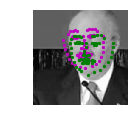

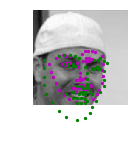

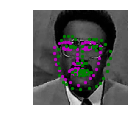

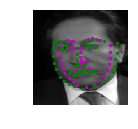

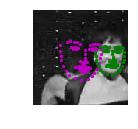

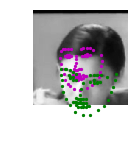

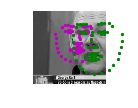

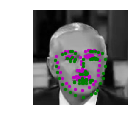

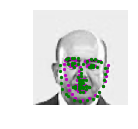

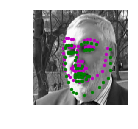

In [44]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [45]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_2.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: I chose Adam optimizer because research has shown that Adam optimizer works well on most tasks, because it intergrates many concepts for optimization together. Also, the research paper on facial keypoints showed from the experiments that Adam optimizer work well on facial keypoits.

I initially chose to use standard MSE loss, as it works for most tasks and is a common choice of loss to start with. Later, as suggested my many classmates, Smooth L1 Loss works better because it is less sensitive to outliers. From observing the photos, I noticed that many photos' ground truth facial keypoints are actually labelled very poorly, some incorrectly. To make sure that our model still works well by not overfitting to outlier data labels, I sticked with the Smooth L1 Loss, which empirically works well.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: I started with a CNN with 4 convolutional layers on custom filter sizes ranging from 64 to 256 increasingly. I added batch normalizations and two fully connected layers with dropouts everywhere. However, they train extremly slowly for some reason -- 15min for one iterations within one epoch. I think it's an issue with the Udacity workshop, so I had to launch a custom AWS instance with GPUs to accelerate my training. The model heavily overfits.

Then, I tried either adding more fully connected layers, having fewer fully connected layers, having fewer convolutional layers, having dropouts between convolutional layers, and even removing batch normalizations. The model will either heavily underfits or overfits.

Later, I moved on to adapt the architecture by the facial detection research paper. I made my filter sizes samller, starting from 32 to 256 with decreasing kernel sizes. I adapted the idea to add a pooling layer after each convolutional layer. I also added 6 dropouts, one after each convolutional or dense layer operation, with decreasing dropout probabilities from 0.1 to 0.6 (increasing step size 0.1). The model still somewhat udnerfits. I changed my activation functions from RELU to ELU, and also initialized the weights of fully connected layers according the "xavier uniform".

Then, I found my bug: the order of batch normalization, pooling layers, and activation functions. It turns out that I should apply batch normalizations before both pooling and activations. The result improved dramatically and is much better at fitting, but still non satisfactory.

Lastly, I chose to add 2D batch normalizations after convolutional operations, which the original paper didn't have due to its huge negative impact on training speed. It improved the model by a lot. After several trails and error, I also added 1D batch normalizations after each fully connected layer, and that did the trick, leading to my best model.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: I decided on the number of epochs primarily based on the rate of the training I observed emperically. Rational is that if I have too much epochs, I can do early stopping as soon as I see it starts to overfit -- losses going up. If I have too few epochs,, I can just add more epochs to keep training. Eventually, due to time constraint and performance result, I choose to do 10 epochs with early stopping.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[ 0.08482028 -0.04927676  0.23359978 -0.03879281]
 [ 0.04944827  0.18750091 -0.22815381 -0.0301388 ]
 [-0.06600957  0.07771968  0.20902789 -0.19672823]
 [ 0.21241005  0.09977034 -0.2487977  -0.25076476]]
(4, 4)


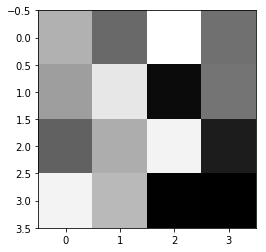

In [46]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

First convolutional layer


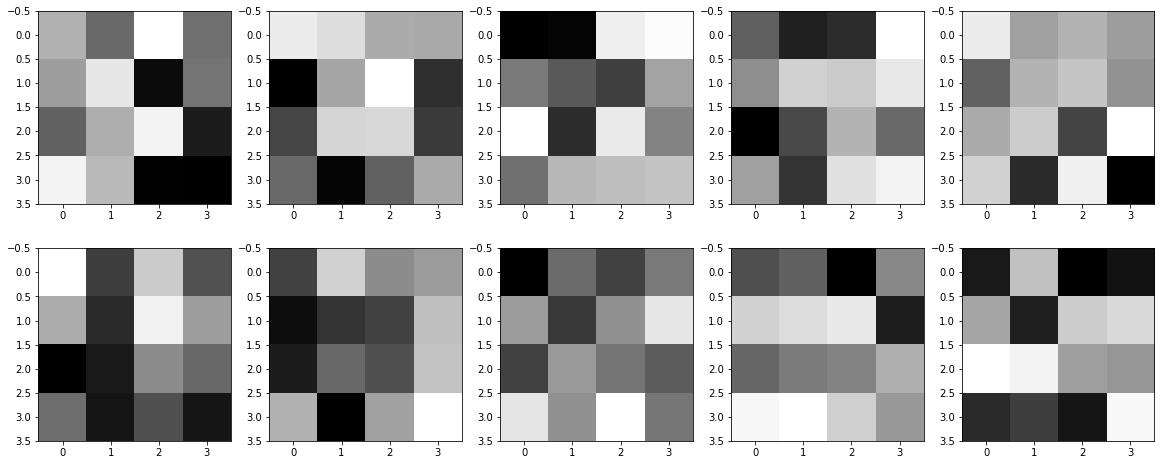

In [47]:
##TODO: load in and display any image from the transformed test dataset

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
weights = net.conv1.weight.data
w = weights.numpy()

# for 10 filters
fig=plt.figure(figsize=(20, 8))
columns = 5
rows = 2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(w[i][0], cmap='gray')
    
print('First convolutional layer')
plt.show()


### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**:  If we look at most of the filters, they are picking up lines in the photo, so their purposes probably serve as edge detectors. It probably helps define features such as the curve of the face, etc. for better localizations of the facial keypoints. If you look at filters such as the first one and some on the right column, the eyebrows and lips are highlighted, so they are probably detecting those facial keypoints

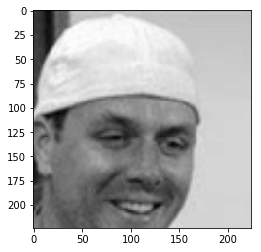

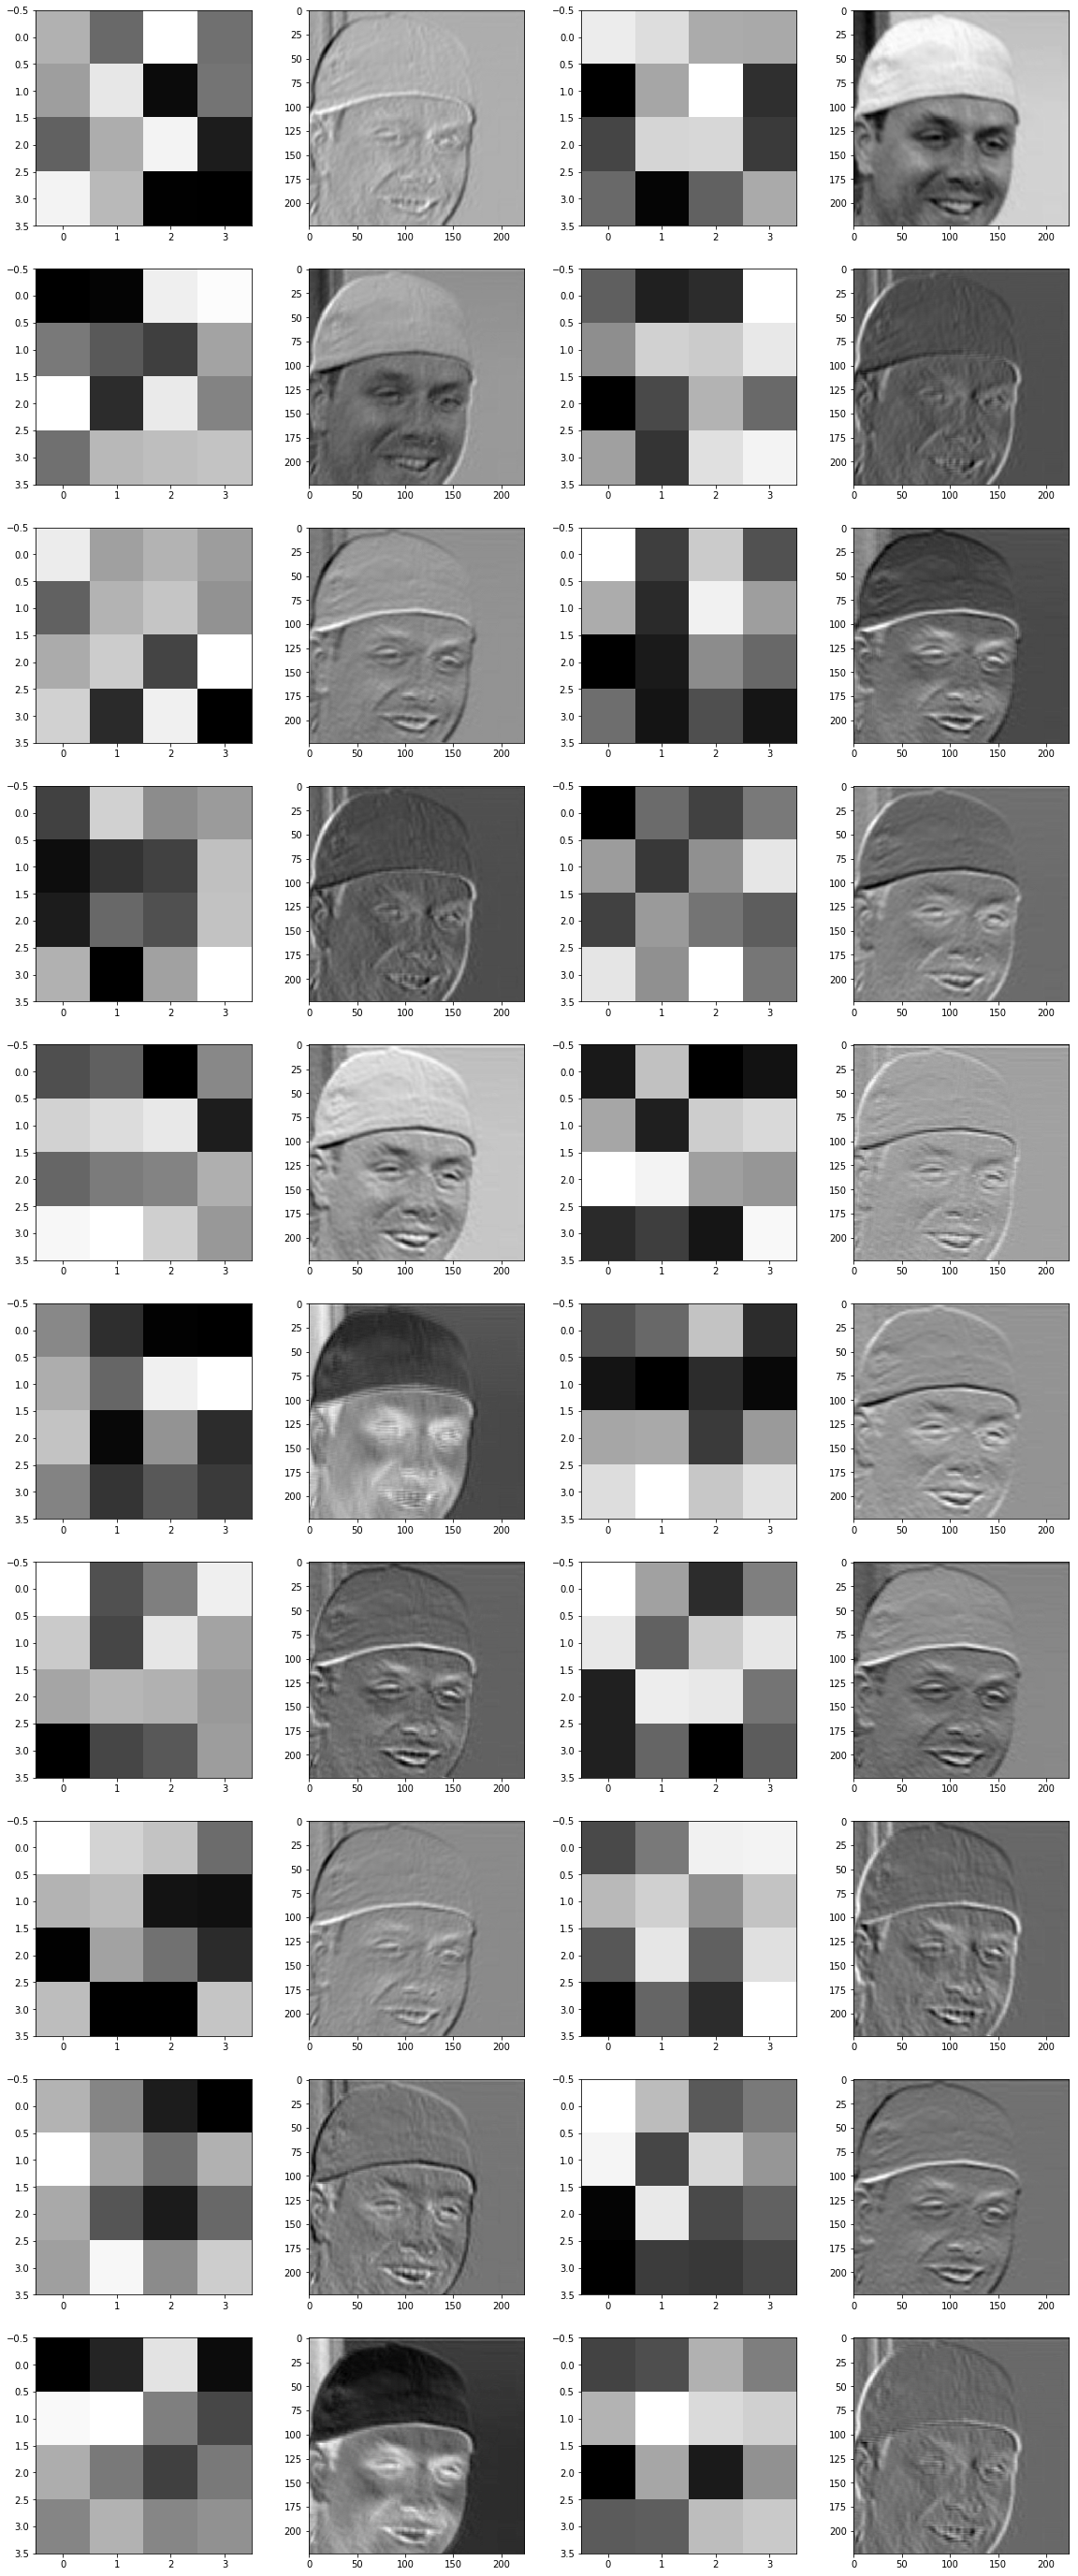

In [48]:
img = np.squeeze(test_images[1])
img = np.array(img)

plt.imshow(img, cmap='gray')
weights = net.conv1.weight.data
w = weights.numpy()

fig=plt.figure(figsize=(20, 50))
columns = 4
rows = 10
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(c, cmap='gray')
plt.show()

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!